 - Dados 1: https://dados.gov.br/dados/conjuntos-dados/medicoes-de-campos-eletromagneticos1 (campos eletromagnéticos)
 - Dados 2: https://www.telecocare.com.br/mapaerbs/ (mapa de erbs do brasil - Anatel)

In [1]:
import pandas as pd
import numpy as np
import math as Math
import matplotlib.pyplot as plt
import datetime

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [2]:
#leitura dos dados
df = pd.read_csv('Medicoes_de_Campos_Eletromagneticos_2016-2020.csv', sep = ';')
df.head(3)

C:\Users\lucas\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3331: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Responsável,Nome Responsável,Data da Medicao,Hora da Medicao,Tipo de Medicao,Latitude,Longitude,Municipio,UF,Valor Medio,% do Limite,Número Estação,Operadora da Estação
0,ANATEL,Agencia Nacional de Telecomunicacoes,01/01/2016,00:00:00,Fixas,"-30,046873","-51,206071",Porto Alegre,RS,"0,27","0,01%",N/I,NaN
1,ANATEL,Agencia Nacional de Telecomunicacoes,01/01/2016,00:00:00,Fixas,"-30,046873","-51,206071",Porto Alegre,RS,"0,4","0,02%",N/I,NaN
2,ANATEL,Agencia Nacional de Telecomunicacoes,01/01/2016,00:00:00,Fixas,"-27,59764","-48,54856",Florianópolis,SC,"0,48","0,03%",N/I,NaN


### Pré-processamento
    
Estipulando os tipos dos dados para cada feature

In [3]:
#ajustando as casas decimais de features numéricas
df['Latitude'] = df['Latitude'].str.replace(',','.')
df['Longitude'] = df['Longitude'].str.replace(',','.')
df['Valor Medio'] = df['Valor Medio'].str.replace(',','.')
df['% do Limite'] = df['% do Limite'].str.replace(',','.')
df['% do Limite'] = df['% do Limite'].str.replace('%','')

#estipulando os tipos dos dados para cada feature
df = df.astype({
    'Responsável': 'str', 
    'Nome Responsável': 'str',
    'Data da Medicao': 'str',
    'Hora da Medicao': 'str',
    'Tipo de Medicao': 'str',
    'Latitude': 'float',
    'Longitude': 'float',
    'Municipio': 'str',
    'UF': 'str',
    'Valor Medio': 'float',
    '% do Limite': 'float',
    'Número Estação': 'str',
    'Operadora da Estação': 'str',
})

#merge na coluna data e hora para um único formato datetime
df.insert(3,'Time',df['Data da Medicao'] + ' ' + df['Hora da Medicao'])
df['Time'] = pd.to_datetime(df['Time'], format = '%d/%m/%Y %H:%M:%S')
df.drop(['Data da Medicao', 'Hora da Medicao'], axis = 1, inplace = True)

df.head()

,Responsável,Nome Responsável,Time,Tipo de Medicao,Latitude,Longitude,Municipio,UF,Valor Medio,% do Limite,Número Estação,Operadora da Estação
0,ANATEL,Agencia Nacional de Telecomunicacoes,2016-01-01,Fixas,-30.046873,-51.206071,Porto Alegre,RS,0.27,0.01,N/I,nan
1,ANATEL,Agencia Nacional de Telecomunicacoes,2016-01-01,Fixas,-30.046873,-51.206071,Porto Alegre,RS,0.40,0.02,N/I,nan
2,ANATEL,Agencia Nacional de Telecomunicacoes,2016-01-01,Fixas,-27.597640,-48.548560,Florianópolis,SC,0.48,0.03,N/I,nan
3,ANATEL,Agencia Nacional de Telecomunicacoes,2016-01-01,Fixas,-25.435801,-49.283723,Curitiba,PR,1.76,0.40,N/I,nan
4,ANATEL,Agencia Nacional de Telecomunicacoes,2016-01-01,Fixas,-20.455133,-54.608875,Campo Grande,MS,0.22,0.01,N/I,nan


### Análise Exploratória de Dados (EDA)
    
    -Observe que há 11 empresas responsáveis pela realização das atividades de medição dos campos eletromagnéticos das ERBs. Entre elas estão a ANATEL e outras.
    -Podem ser realizados 3 tipos de medição: Fixas, Móveis ou Faixa Larga.
    -Foram feitas medições em 4153 municípios distintos, abrangendo 27 estados da federação.
    -Desconhece-se a maior parte das operadoras das estações rádio-base (72%), sendo que as duas operadoras majoritárias conhecidas são a TIM S/A(10,2%) e a CLARO S.A.(8,4%).

In [4]:
#resumo sobre os tipos dos dados
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 642584 entries, 0 to 642583
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Responsável           642584 non-null  object        
 1   Nome Responsável      642584 non-null  object        
 2   Time                  642584 non-null  datetime64[ns]
 3   Tipo de Medicao       642584 non-null  object        
 4   Latitude              642584 non-null  float64       
 5   Longitude             642584 non-null  float64       
 6   Municipio             642584 non-null  object        
 7   UF                    642584 non-null  object        
 8   Valor Medio           642584 non-null  float64       
 9   % do Limite           642584 non-null  float64       
 10  Número Estação        642584 non-null  object        
 11  Operadora da Estação  642584 non-null  object        
dtypes: datetime64[ns](1), float64(4), object(7)
memory usage: 

,Latitude,Longitude,Valor Medio,% do Limite
count,642584.000000,642584.000000,642584.000000,642584.000000
mean,-14.927472,-47.514809,0.725833,0.158085
std,8.411809,7.933077,0.844848,0.717145
min,-33.690330,-72.907440,0.010000,0.000000
25%,-20.455133,-52.257787,0.280000,0.010000
50%,-15.805153,-47.882726,0.470000,0.030000
75%,-8.761610,-42.800817,0.900000,0.100000
max,3.842410,-32.401240,27.960000,99.710000


In [5]:
#informações básicas sobre o dataset
print(f'Total de empresas responsáveis: {len(df["Nome Responsável"].unique())}')
print(f'Tipos de medição: {len(df["Tipo de Medicao"].unique())}')
print(f'Total de Municípios Distintos: {len(df["Municipio"].unique())}')
print(f'Total de Unidades da Federação: {len(df["UF"].unique())}')
print('\nPercentual de estações por operadora:')
df['Operadora da Estação'].value_counts(normalize = True)

Total de empresas responsáveis: 11
Tipos de medição: 3
Total de Municípios Distintos: 4153
Total de Unidades da Federação: 27

Percentual de estações por operadora:


nan                                0.721381
TIM S/A                            0.101872
CLARO S.A.                         0.083917
TELEFÔNICA BRASIL S.A.             0.045463
NEXTEL TELECOMUNICACOES LTDA       0.036465
TELEFONICA BRASIL S.A.             0.005335
ALGAR TELECOM S/A                  0.003721
SERCOMTEL S.A. TELECOMUNICAÇÕES    0.000932
SERCOMTEL CELULAR S.A.             0.000913
Name: Operadora da Estação, dtype: float64

In [6]:
#datafrane filtrado para a região de Anápolis
df_anapolis = df[(df['UF'] == 'GO') & (df['Municipio'] == 'Anápolis')]

#Latitudes e Longitudes mínimas e máximas encontradas para locais de medição na cidade de Anápolis
latmin_anapolis = min(df_anapolis['Latitude'])
latmax_anapolis = max(df_anapolis['Latitude'])
longmin_anapolis = min(df_anapolis['Longitude'])
longmax_anapolis = max(df_anapolis['Longitude'])

#Latitudes e Longitudes mínimas e máximas encontradas para locais de medição em todo o Brasil
latmin_bra = min(df['Latitude'])
latmax_bra = max(df['Latitude'])
longmin_bra = min(df['Longitude'])
longmax_bra = max(df['Longitude'])
print('\nLatitudes/Longitudes mínimas e máximas encontradas para as medições efetuadas:\n')
print(f'Brasil\nlatmin: {latmin_bra}\nlatmax: {latmax_bra}\nlongmin: {longmin_bra}\nlongmax: {longmax_bra}\n')
print(f'Anápolis\nlatmin: {latmin_anapolis}\nlatmax: {latmax_anapolis}\nlongmin: {longmin_anapolis}\nlongmax: {longmax_anapolis}\n')


Latitudes/Longitudes mínimas e máximas encontradas para as medições efetuadas:

Brasil
latmin: -33.69033
latmax: 3.84241
longmin: -72.90744
longmax: -32.40124

Anápolis
latmin: -16.41152
latmax: -16.25403
longmin: -48.99911
longmax: -48.7867



Extração das características geográficas dos mapas pelas coordenadas
    
Bounding boxes para: Brasil e Anápolis
    
https://www.openstreetmap.org/

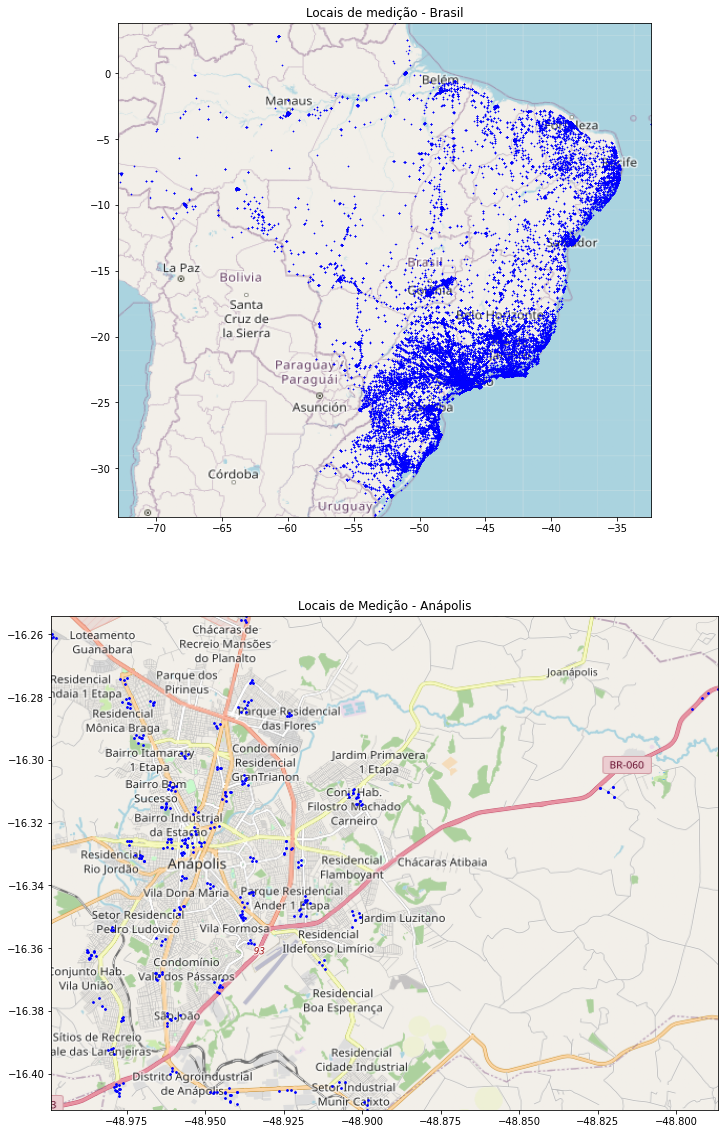

In [7]:
#Bounding Box para o Brasil e para Anápolis. Finalidade: extração dos mapas pelas coordenadas
BBox_bra = ((longmin_bra, longmax_bra, latmin_bra, latmax_bra))
BBox_anapolis = ((longmin_anapolis, longmax_anapolis, latmin_anapolis, latmax_anapolis))

#mapas gerados pelo openstreetmap.org
brasil = plt.imread('brasil.png')
anapolis = plt.imread('anapolis.png')

#locais de medição no brasil
fig, axs = plt.subplots(2,1,figsize = (16,20))
axs[0].scatter(df.Longitude, df.Latitude, zorder=1, alpha= 1, c='b', s=0.1)
axs[0].set_title('Locais de medição - Brasil')
axs[0].set_xlim(BBox_bra[0],BBox_bra[1])
axs[0].set_ylim(BBox_bra[2],BBox_bra[3])
axs[0].imshow(brasil, zorder=0, extent = BBox_bra, aspect= 'equal')

#locais de medição em Anápolis
axs[1].scatter(df_anapolis.Longitude, df_anapolis.Latitude, zorder=1, alpha= 1, c='b', s=3)
axs[1].set_title('Locais de Medição - Anápolis')
axs[1].set_xlim(BBox_anapolis[0],BBox_anapolis[1])
axs[1].set_ylim(BBox_anapolis[2],BBox_anapolis[3])
axs[1].imshow(anapolis, zorder=0, extent = BBox_anapolis, aspect= 'equal')

### Algoritmos não-supervisionados
    
Elbow method para identificar clusterização ideal para o algoritmo KMeans. Observe que k = 5 fornece uma aparente clusterização ideal. Para esse caso, observe como o algoritmo parece diferenciar naturalmente entre regiões norte, nordeste, centro-oeste, sudeste e sul.

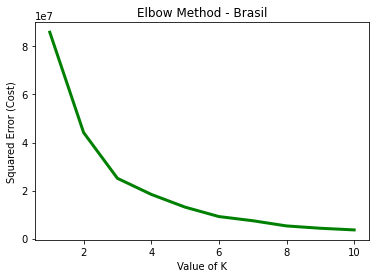

In [8]:
def elbow_method(X,title):
    cost =[]
    for i in range(1, 11):
        KM = KMeans(n_clusters = i, max_iter = 500, n_init=10)
        KM.fit(X)

        # calculates squared error
        # for the clustered points
        cost.append(KM.inertia_)    

    # plot the cost against K values
    plt.plot(range(1, 11), cost, color ='g', linewidth ='3')
    plt.title(title)
    plt.xlabel("Value of K")
    plt.ylabel("Squared Error (Cost)")
    plt.show() # clear the plot
    
elbow_method(df[['Latitude','Longitude']], 'Elbow Method - Brasil')

KMeans

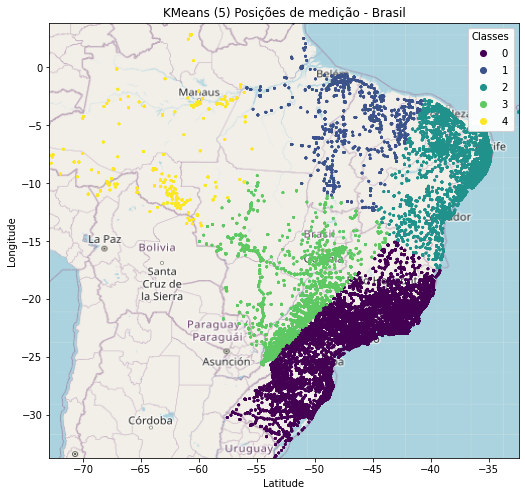

In [9]:
def plot_kmeans(k,df,xcol,ycol):
    X = df[[xcol,ycol]]
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(X)
    predictions = kmeans.predict(X)
    
    BBox_bra = ((longmin_bra, longmax_bra, latmin_bra, latmax_bra))
    brasil = plt.imread('brasil.png')
    
    fig, axs = plt.subplots(1,1,figsize = (16,8))
    scatter = axs.scatter(df.Longitude, df.Latitude, zorder=1, alpha= 1, c=predictions, s=3)
    axs.set_title(f'KMeans ({k}) Posições de medição - Brasil')
    axs.set_xlim(BBox_bra[0],BBox_bra[1])
    axs.set_ylim(BBox_bra[2],BBox_bra[3])
    legend1 = axs.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
    axs.add_artist(legend1)
    axs.set_xlabel(xcol)
    axs.set_ylabel(ycol)
    axs.imshow(brasil, zorder=0, extent = BBox_bra, aspect= 'equal')
    
plot_kmeans(5, df, 'Latitude', 'Longitude')

### Análise Exploratória de Dados (EDA) e Pré-processamento (Base 2)
    
Leitura de dataset secundário: Localização de todas as ERBs no Brasil
    
https://www.telecocare.com.br/mapaerbs/ (mapa de erbs do brasil - Anatel)
    
Realizado um merge entre as duas bases de dados (Base das medições e Base da localização das ERBs) de forma a agregar as respectivas instâncias correspondentes de acordo com os números das estações (valor que está presente em ambas as bases).
    
O dataframe resultante é o mdf.

In [10]:
dferb = pd.read_csv('erbs.csv', sep=';', encoding = 'utf-8')
dferb.rename(columns={'NumEstacao':'Número Estação', 'Latitude':'ErbLat', 'Longitude':'ErbLong'}, inplace = True)
dferb = dferb.astype({
    'Número Estação':'str',
    'ErbLat':'float',
    'ErbLong':'float'
})

mdf = pd.merge(df, dferb, how = 'inner', on = 'Número Estação')
mdf.drop(['Operadora','SiglaUf','MUN','Bairro','LOGRADOURO','IBGE','Tecs'], axis = 1, inplace = True)
mdf.info()
mdf.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151527 entries, 0 to 151526
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Responsável           151527 non-null  object        
 1   Nome Responsável      151527 non-null  object        
 2   Time                  151527 non-null  datetime64[ns]
 3   Tipo de Medicao       151527 non-null  object        
 4   Latitude              151527 non-null  float64       
 5   Longitude             151527 non-null  float64       
 6   Municipio             151527 non-null  object        
 7   UF                    151527 non-null  object        
 8   Valor Medio           151527 non-null  float64       
 9   % do Limite           151527 non-null  float64       
 10  Número Estação        151527 non-null  object        
 11  Operadora da Estação  151527 non-null  object        
 12  ErbLat                151527 non-null  float64       
 13 

,Responsável,Nome Responsável,Time,Tipo de Medicao,Latitude,Longitude,Municipio,UF,Valor Medio,% do Limite,Número Estação,Operadora da Estação,ErbLat,ErbLong
0,ANATEL,Agência Nacional de Telecomunicações,2016-01-27 16:30:00,Fixas,-10.503258,-39.008258,Euclides da Cunha,BA,0.35,0.02,695504177,TIM S/A,-10.503278,-39.008528
1,ANATEL,Agência Nacional de Telecomunicações,2016-01-27 16:40:00,Fixas,-10.502900,-39.008733,Euclides da Cunha,BA,0.37,0.02,695504177,TIM S/A,-10.503278,-39.008528
2,ANATEL,Agência Nacional de Telecomunicações,2016-01-27 16:50:00,Fixas,-10.503967,-39.008739,Euclides da Cunha,BA,0.37,0.02,695504177,TIM S/A,-10.503278,-39.008528
3,OUTRAS,Associação Brasileira de Compatibilidade Eletr...,2018-04-11 12:29:00,Faixa Larga,-10.503260,-39.008380,Euclides da Cunha,BA,0.37,0.02,695504177,TIM S/A,-10.503278,-39.008528
4,OUTRAS,Associação Brasileira de Compatibilidade Eletr...,2018-04-11 12:36:37,Faixa Larga,-10.502460,-39.007460,Euclides da Cunha,BA,0.44,0.02,695504177,TIM S/A,-10.503278,-39.008528


### Feature Engineering
    
Criação da feature distância (entre as ERBs e seus pontos de medição). Utilização da Fórmula de Haversine para determinar a distância entre dois pontos ao longo de uma superfície esférica, dadas suas latitudes e longitudes.
    
https://en.wikipedia.org/wiki/Haversine_formula

In [11]:
#Fórmula de Haversine: distância entre 2 pontos em superfície esférica, dadas latitude/longitude
def getDistanceFromLatLonInKm(lat1,lon1,lat2,lon2):
    R = 6371;
    dLat = deg2rad(lat2-lat1)
    dLon = deg2rad(lon2-lon1) 
    a =  Math.sin(dLat/2) * Math.sin(dLat/2) + Math.cos(deg2rad(lat1)) * Math.cos(deg2rad(lat2)) * Math.sin(dLon/2) * Math.sin(dLon/2)
    c = 2 * Math.atan2(Math.sqrt(a), Math.sqrt(1-a))
    d = R * c
    return d

#conversão de graus para radianos
def deg2rad(deg):
    return deg * (Math.pi/180)

#criação da feature distância
mdf['Distancia'] = np.vectorize(getDistanceFromLatLonInKm)(mdf['ErbLat'], mdf['ErbLong'], mdf['Latitude'], mdf['Longitude'])

#fornecer a distância em metros
mdf['Distancia'] *= 1000

# mdf['ts'] = mdf['Time'].apply(lambda x: (x-datetime.datetime(1970,1,1)).total_seconds())
# mdf['ts'] =(mdf['ts']-mdf['ts'].min())/(mdf['ts'].max()-mdf['ts'].min())
mdf.head(3)

,Responsável,Nome Responsável,Time,Tipo de Medicao,Latitude,Longitude,Municipio,UF,Valor Medio,% do Limite,Número Estação,Operadora da Estação,ErbLat,ErbLong,Distancia
0,ANATEL,Agência Nacional de Telecomunicações,2016-01-27 16:30:00,Fixas,-10.503258,-39.008258,Euclides da Cunha,BA,0.35,0.02,695504177,TIM S/A,-10.503278,-39.008528,29.577163
1,ANATEL,Agência Nacional de Telecomunicações,2016-01-27 16:40:00,Fixas,-10.502900,-39.008733,Euclides da Cunha,BA,0.37,0.02,695504177,TIM S/A,-10.503278,-39.008528,47.623727
2,ANATEL,Agência Nacional de Telecomunicações,2016-01-27 16:50:00,Fixas,-10.503967,-39.008739,Euclides da Cunha,BA,0.37,0.02,695504177,TIM S/A,-10.503278,-39.008528,80.041769


### Análise Exploratória de Dados (EDA)
Plotagem dos locais das medições (azul) e das posições das ERBs (vermelho)

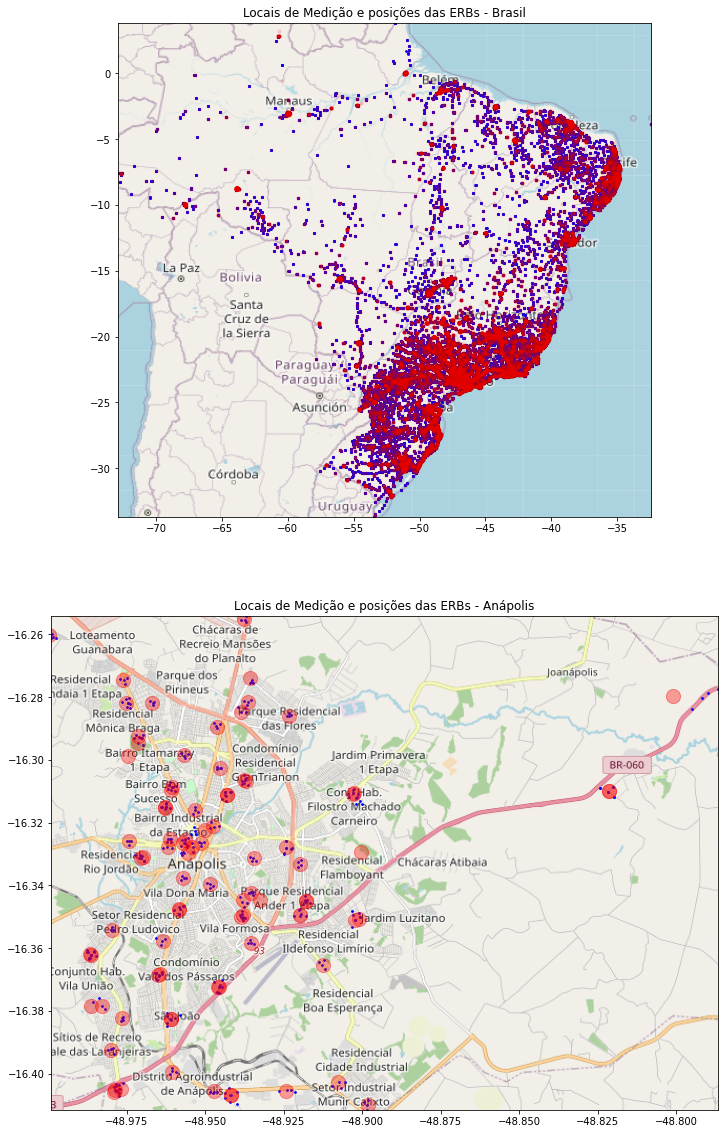

In [12]:
#dataframe apenas com dados de Anápolis
mdf_anapolis = mdf[(mdf['UF'] == 'GO') & (mdf['Municipio'] == 'Anápolis')]

#coordenadas máximas e mínimas das medições em Anápolis
latmin_anapolis = min(mdf_anapolis['Latitude'])
latmax_anapolis = max(mdf_anapolis['Latitude'])
longmin_anapolis = min(mdf_anapolis['Longitude'])
longmax_anapolis = max(mdf_anapolis['Longitude'])

#coordenadas máximas e mínimas das medições no Brasil
latmin_bra = min(mdf['Latitude'])
latmax_bra = max(mdf['Latitude'])
longmin_bra = min(mdf['Longitude'])
longmax_bra = max(mdf['Longitude'])

#bounding boxes para o Brasil e Anápolis (finalidade: extração de mapa)
BBox_bra = ((longmin_bra, longmax_bra, latmin_bra, latmax_bra))
BBox_anapolis = ((longmin_anapolis, longmax_anapolis, latmin_anapolis, latmax_anapolis))

brasil = plt.imread('brasil.png')
anapolis = plt.imread('anapolis.png')

#plotagem do locais das medições (azul) e das posições das ERBs (vermelho)
fig, axs = plt.subplots(2,1,figsize = (16,20))
axs[0].scatter(mdf.Longitude, mdf.Latitude, zorder=1, alpha= 1, c='b', s=3)
axs[0].scatter(mdf.ErbLong, mdf.ErbLat, zorder=1, alpha= 0.03, c='r', s=10)
axs[0].set_title('Locais de Medição e posições das ERBs - Brasil')
axs[0].set_xlim(BBox_bra[0],BBox_bra[1])
axs[0].set_ylim(BBox_bra[2],BBox_bra[3])
axs[0].imshow(brasil, zorder=0, extent = BBox_bra, aspect= 'equal')

axs[1].scatter(mdf_anapolis.Longitude, mdf_anapolis.Latitude, zorder=1, alpha= 1, c='b', s=3)
axs[1].scatter(mdf_anapolis.ErbLong, mdf_anapolis.ErbLat, zorder=1, alpha= 0.1, c='r', s=200)
axs[1].set_title('Locais de Medição e posições das ERBs - Anápolis')
axs[1].set_xlim(BBox_anapolis[0],BBox_anapolis[1])
axs[1].set_ylim(BBox_anapolis[2],BBox_anapolis[3])
axs[1].imshow(anapolis, zorder=0, extent = BBox_anapolis, aspect= 'equal')

Relação entre as distâncias (metros) dos pontos de medição e suas respectivas ERBs relacionadas.
    
Observe que o gráfico obtido é bastante semelhante ao gráfico fornecido pela análise do Prof. Ph.D Marco Antonio Brasil Terada em "Análise da Intensidade de Campo Elétrico de Estações Rádio-Base". 
    
TERADA, Marco Antonio Brasil. Análise da Intensidade de Campo Elétrico de Estações Rádio-Base. Inatel, 2008. Disponível em: https://www.inatel.br/revista/busca/144-5-analise-da-intensidade-de-campo-s504918-1/file>. Acesso em: 21/12/2022.

Text(0, 0.5, 'Valor médio (V/m) do campo elétrico')

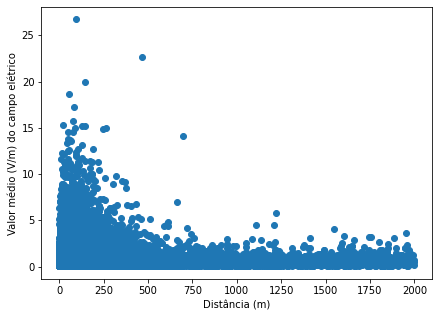

In [13]:
dmax = 2000
fig, axs = plt.subplots(1,1, figsize=(7,5))
axs.scatter(mdf[mdf['Distancia'] < dmax]['Distancia'], mdf[mdf['Distancia'] < dmax]['Valor Medio'])
axs.set_xlabel('Distância (m)')
axs.set_ylabel('Valor médio (V/m) do campo elétrico')

<img align="left" src="grafico_artigo_campos_erbs.png">

### Algoritmos não-supervisionados
    
DBSCAN
    
Observe que o algoritmo agrega boa parte dos dados até a distância de aproximadamente 750m. Possivelmente essa informação corrobore com as regiões de campo próximo (Fresnel) e regiões de campo distante (Fraunhofer) para antenas.

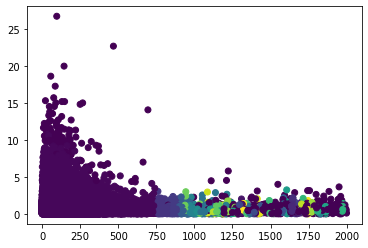

In [14]:
ff = mdf[mdf['Distancia'] <= 2000]
clusters = DBSCAN(eps=2.5, min_samples=8).fit(ff[['Distancia','Valor Medio']])
plt.scatter(ff['Distancia'], ff['Valor Medio'], c = clusters.labels_)

### Análise Exploratória de Dados (EDA)
    

[1.00000000e+01 9.36258108e-18]


1.2395102977514314

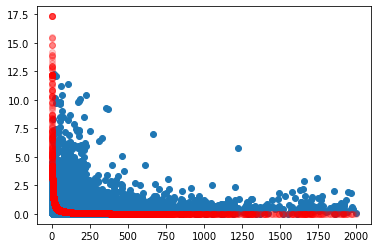

In [15]:
def func(x, w, g):
    return ( (30 * w * 10 ** (g / 10)) ** (0.5) )/ (x + 1)

def custom_mse(y, ypred):
    diff = y - ypred
    diff_squared = diff ** 2
    return sum(diff_squared) / len(diff_squared)

fdf = mdf.loc[mdf['Distancia'] <= 2000,['Distancia','Valor Medio']]

# X = fdf.drop(['Valor Medio'], axis = 1)
# y = fdf['Valor Medio']
X = fdf['Distancia']
y = fdf['Valor Medio']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 47)

popt, _ = curve_fit(func, X_train, y_train, p0 = [30,4], bounds = ([10,0],[80,10]))
w, g = popt

print(popt)
plt.scatter(X_test , y_test)
plt.scatter(X_test,func(X_test, w, g), color = 'red', alpha = 0.2)

custom_mse(y_test, func(X_test, w, g))
# r2_score(y_test,func(X_test, w, g))

Observe a seguir que as variáveis de Latitude e Longitude dos locais das medições e das localizações das ERBs estão altamente correlacionadas. A explicação para isso se deve ao fato de que as medições foram efetuadas nas imediações das antenas, ou seja, em posições geográficas relativamente próximas e, portanto, bem correlacionadas.
    
Constata-se também que as variáveis Valor Médio (do campo eletromagnético) e % do Limite (do campo eletromagnético) também apresentam forte correlação. Ainda, quando calculada a correlação de Spearman, verifica-se que existe alguma correlação não-linear ainda mais acentuada entre o Valor Médio e o % do Limite. Essa correlação (Spearman) não exige que a relação entre as variáveis seja linear. Em outras palavras, o coeficiente avalia com que intensidade a relação entre duas variáveis pode ser descrita pelo uso de uma função monótona.

In [17]:
mdf_anapolis.corr('pearson')

,Latitude,Longitude,Valor Medio,% do Limite,ErbLat,ErbLong,Distancia
Latitude,1.000000,0.130774,0.068504,0.068266,0.995687,0.125528,0.110011
Longitude,0.130774,1.000000,-0.137089,-0.090238,0.132782,0.998769,0.145605
Valor Medio,0.068504,-0.137089,1.000000,0.903206,0.066916,-0.135012,0.012881
% do Limite,0.068266,-0.090238,0.903206,1.000000,0.069284,-0.087929,-0.007715
ErbLat,0.995687,0.132782,0.066916,0.069284,1.000000,0.128548,0.025881
ErbLong,0.125528,0.998769,-0.135012,-0.087929,0.128548,1.000000,0.127578
Distancia,0.110011,0.145605,0.012881,-0.007715,0.025881,0.127578,1.000000


In [18]:
mdf_anapolis.corr('spearman')

,Latitude,Longitude,Valor Medio,% do Limite,ErbLat,ErbLong,Distancia
Latitude,1.000000,0.102088,0.031323,0.032610,0.994665,0.097032,0.008851
Longitude,0.102088,1.000000,-0.109388,-0.108421,0.094534,0.997995,0.088869
Valor Medio,0.031323,-0.109388,1.000000,0.991632,0.020315,-0.109670,0.131326
% do Limite,0.032610,-0.108421,0.991632,1.000000,0.021215,-0.108915,0.138618
ErbLat,0.994665,0.094534,0.020315,0.021215,1.000000,0.089134,-0.025060
ErbLong,0.097032,0.997995,-0.109670,-0.108915,0.089134,1.000000,0.091709
Distancia,0.008851,0.088869,0.131326,0.138618,-0.025060,0.091709,1.000000


Observe a seguir que  as features Valor Médio e % do Limite estão fortemente correlacionadas. Ainda, apresentam uma correspondência semelhante a uma relação quadrática.

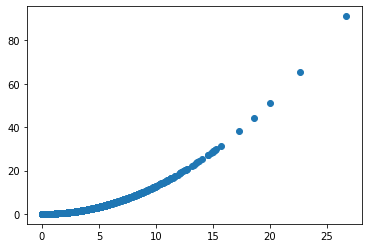

In [19]:
plt.scatter(mdf['Valor Medio'], mdf['% do Limite'])

A seguir, é realizada uma função de ajuste (a uma função quadrática) entre as variáveis anteriormente mencionadas ( Valor Médio e % do Limite). Os resultados apresentados pelo ajuste revelam que essencialmente a relação entre as variáveis se dá por: 
    
% do Limite = 0.1275 * Valor Médio²
    
A correlação obtida é de 99,99%

Valor dos parâmetros de ajuste:
a:0.1275	b:0.0004	c:-0.0003

Coeficiente r2: 0.9999757194233326


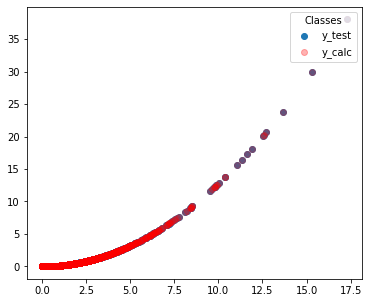

In [60]:
def func(x, a, b, c):
    return a * (x**2) + b * x + c

def custom_mse(y, ypred):
    diff = y - ypred
    diff_squared = diff ** 2
    return sum(diff_squared) / len(diff_squared)

fdf = mdf

X = fdf.drop(['% do Limite'], axis = 1)
y = fdf['% do Limite']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 47)

popt, _ = curve_fit(func, X_train['Valor Medio'], y_train)
a, b, c = popt

print(f'Valor dos parâmetros de ajuste:\na:{round(a,4)}\tb:{round(b,4)}\tc:{round(c,4)}')
fig, axs = plt.subplots(1,1,figsize=(6,5))
axs.scatter(X_test['Valor Medio'] , y_test, alpha = 1)
axs.scatter(X_test['Valor Medio'],func(X_test['Valor Medio'], a, b, c), color = 'red', alpha = 0.3)
legend1 = axs.legend(['y_test', 'y_calc'], loc="upper right", title="Classes")

# custom_mse(y, func(X['Distancia'], a))
# r2_score(y_test,func(X_test['Valor Medio'], a, b, c))

y_calc = a * (X_test['Valor Medio'] ** 2)

print(f'\nCoeficiente r2: {r2_score(y_test, y_calc)}')


### Algoritmos supervisionados
    
Algoritmos supervisionados entre as variáveis Valor Médio e % do Limite

In [36]:
#separation features and target
X = mdf_anapolis[['Valor Medio']]
y = mdf_anapolis['% do Limite']

modelos = []
modelos.append(('LR', LinearRegression()))
modelos.append(('RDG', Ridge()))
modelos.append(('LSS', Lasso()))
modelos.append(('DTR', DecisionTreeRegressor()))
# modelos.append(('KNNR', KNeighborsRegressor()))
# modelos.append(('SVR', SVR()))

for modelo in modelos:
    nome = modelo[0]
    modelo_aplicado = modelo[1]
    scoring = 'r2'
    kfold = KFold(n_splits=5, shuffle = True)
    resultados = cross_val_score(modelo_aplicado, np.array(X),np.array(y), cv=kfold, scoring=scoring)
    print(f'Índice {scoring} com média de {nome}: {resultados.mean()}')

Índice r2 com média de LR: 0.3738327388584676
Índice r2 com média de RDG: -0.16609387014189858
Índice r2 com média de LSS: -0.06146909125810045
Índice r2 com média de DTR: 0.9514544401337751


Algoritmos supervisionados entre as variáveis Distância e Valor Médio

In [62]:
#separation features and target
X = mdf_anapolis[['Distancia']]
y = mdf_anapolis['Valor Medio']

modelos = []
modelos.append(('LR', LinearRegression()))
modelos.append(('RDG', Ridge()))
modelos.append(('LSS', Lasso()))
modelos.append(('DTR', DecisionTreeRegressor()))
# modelos.append(('KNNR', KNeighborsRegressor()))
# modelos.append(('SVR', SVR()))

for modelo in modelos:
    nome = modelo[0]
    modelo_aplicado = modelo[1]
    scoring = 'r2'
    kfold = KFold(n_splits=5, shuffle = True)
    resultados = cross_val_score(modelo_aplicado, np.array(X),np.array(y), cv=kfold, scoring=scoring)
    print(f'Índice escolhido com média de {nome}: {resultados.mean()}')

Índice escolhido com média de LR: -0.04405437695991723
Índice escolhido com média de RDG: -0.0511824167280198
Índice escolhido com média de LSS: -0.03849927546041636
Índice escolhido com média de DTR: -1.7259022502551815
